In [30]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [4]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [31]:
#Reading dataset 
data=pd.read_csv(r"C:\Users\neema\OneDrive\Desktop\Neema\Essex Class\dissertation\cyntia\Clustered_influencers_and_competitor_data\Influencer_data.csv", encoding='latin-1', low_memory=False)

In [32]:
data.head()

,influencer_username,Text
0,aaroncgshore,crack work morning cheer always help cheer lad...
1,adamcollard,"back natural habitat, work capacity wednesday ..."
2,aliceliveing,feel sorry spending sunday thought good time w...
3,brown.elle,"pretty pink iworkwithprimark, missguided, swit..."
4,charlottedawsy,ere still ere living best lyf espanol phone ph...


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(data['Text'])

In [34]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
     }

In [35]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

for k in range(2, 12):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(X)
  score = silhouette_score(X, kmeans.labels_)
  silhouette_coefficients.append(score)

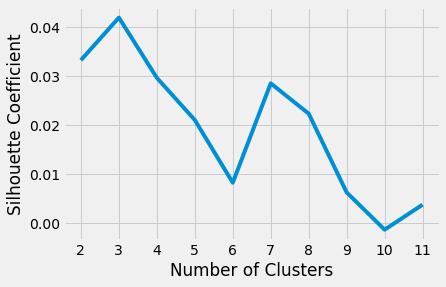

In [36]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 12), silhouette_coefficients)
plt.xticks(range(2, 12))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [37]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
labels=kmeans.labels_
Influencer=pd.DataFrame(list(zip(data['influencer_username'],labels)),columns=['influencer_username','cluster'])
print(Influencer.sort_values(by=['cluster']))

   influencer_username  cluster
3           brown.elle        0
26            sylvijaa        0
24         rogersnipes        1
1          adamcollard        1
2         aliceliveing        1
27        thebodycoach        1
25       slimmingworld        1
7       courtneydblack        1
20      mac_griffiths_        1
9       gabbydawnallen        1
11       itsalwayshana        1
28     thefitnesschef_        1
13        jamessmithpt        1
21     mattdoesfitness        2
0         aaroncgshore        2
23        oliviadbowen        2
22             ohpolly        2
19           lucymeck1        2
14           jesshunt2        2
17         katiepiper_        2
16        jesswright77        2
15     jessica_rose_uk        2
12         jamesgshore        2
10           ini.helen        2
8   danosborneofficial        2
6           chloe.khan        2
5          chessieking        2
4       charlottedawsy        2
18         korisampson        2
29        _jackfowler_        2


In [38]:
new_column = kmeans.fit_predict(X)
data["Cluster"] = new_column
new_influnencer_cluster=data

In [40]:
new_influnencer_cluster.to_csv('ClusteredInfluencers.csv', index=False)

In [41]:
#Reading dataset 
brand_data=pd.read_csv(r"C:\Users\neema\OneDrive\Desktop\Neema\Essex Class\dissertation\cyntia\Clustered_influencers_and_competitor_data\data_competitors.csv", encoding='latin-1', low_memory=False)
brand_data.head()

,Unnamed: 0,competitor_name,platform,text
0,0,bulk,facebook,delicious barbecue low calorie sauce perfect l...
1,1,bulk,facebook,make let know goal teambulk
2,2,bulk,facebook,get ahead health wellbeing range offer target ...
3,3,bulk,facebook,start week right start protein pancake perfect...
4,4,bulk,facebook,create dream blending hemp pumpkin powerfully ...


In [24]:
pip install -U sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [25]:
import itertools
import re
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow_hub as hub
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

In [26]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [27]:
conda install h5py

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done



In [28]:
def get_median_similarity(model, ps1, ps2):
    """Calculates the average of the similarity score based on all the combinations of these two lists of texts.
    Using the Universal sentence encoder model."""
    sm_scores = []
    try:
        sembs_1 = model(ps1).numpy()  # Sentence embeddings for the first list of posts
        sembs_2 = model(ps2).numpy()  # Sentence embeddings for the second list of posts

        for semb in sembs_1:
            sm_scores.extend(cosine_similarity([semb], sembs_2))
    except Exception as e:
        print(e)
        # print(ps1)
        # print(ps2)
    return np.median(sm_scores)

In [29]:
def competitor_influencerCluster_similarity():
    """Do the similarity analysis between all the competitors and influencer clusters"""
    df_competitors = pd.read_csv(r"C:\Users\neema\OneDrive\Desktop\Neema\Essex Class\dissertation\cyntia\Clustered_influencers_and_competitor_data\data_competitors.csv")
    df_influencersclusters = new_influnencer_cluster
    # Dropping the null values if there are any
    df_influencersclusters.dropna(inplace=True)
    df_competitors.dropna(inplace=True)
    df_competitors = df_competitors[df_competitors['platform'] != 'website']

    # Loading the sentence transformers model.
    #bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
    use_model = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')


    # Getting unique values of competitor and influencer names as a list
    cmptr_list = df_competitors['competitor_name'].unique().tolist()
    inflcr_list = df_influencersclusters['Cluster'].unique().tolist()

    final_scores = []
    # Iterating through all the competitors
    for cmptr in cmptr_list:
        # Getting all the posts belonging to the competitor given by 'cmptr'
        cmptr_posts = df_competitors.loc[df_competitors['competitor_name'] == cmptr, 'text'].tolist()
        # Iterating through all the influencers
        for inflcr in inflcr_list:
            # Getting all the posts belonging to the influencer cluster given by 'inflcr'
            inflcr_posts = df_influencersclusters.loc[df_influencersclusters['Cluster'] == inflcr, 'Text'].tolist()
            print('Finding similarity between the competitor', cmptr, ' and the influencer cluster', inflcr, '...')
            # Appending to the" list of similarity scores for each combination of competitor and influencer cluster.
            final_scores.append(
                (cmptr, inflcr, get_median_similarity(model=use_model, ps1=cmptr_posts, ps2=inflcr_posts)))

            # Saving the results for every iteration.
            df_similarity = pd.DataFrame(final_scores,
                                         columns=['competitor_name', 'Cluster', 'similarity_score'])
            df_similarity.to_csv('competitor_influencercluster_similarity.csv', index=False)
competitor_influencerCluster_similarity()

OSError: SavedModel file does not exist at: C:\Users\neema\AppData\Local\Temp\tfhub_modules\063d866c06683311b44b4992fd46003be952409c\{saved_model.pbtxt|saved_model.pb}